<a id='intro'></a>
## Introduction

> ## Dataset
The dataset being analyzed contains match, player, team and betting data for European Professional Football, from the years 2008 to 2016. Data is presented in the form of a SQL database, in which there are tables for Country, League, Match, Player, Player Attributes, Team and Team Attributes.

> ## Questions
With the provided data, it is important to ask relevant questions to gain meaningful insights. Furthermore, for the scope of this report questions which require machine learning and/or deep learning applications should be omitted. The following quesions are therefore considered:
> ### Player Attributes
1. How does a player's height influence their overall rating?
2. How does a player's age influence their overall rating?
> ### Team Attributes
1. Which team has the highest win/loss ratio?
2. What are the attributes for the team with the highest win/loss ratio?


In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html

import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

path = "../"
database = path + "database.sqlite"

<a id='wrangling'></a>
## Data Wrangling

The data will be read using sql queries, with pandas' `read_sql` method. This makes inteacting with the database direct and straightforward.
In this exploration only the first few rows of each table will be read, to better understand the data, and the entity relationships (since an entity relationship diagram is not provided).

In [2]:
# Loading Data

conn = sqlite3.connect(database)

pd.read_sql("""SELECT * FROM Player LIMIT 5;""", conn, index_col="id")

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
id,,,,,,
1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [3]:
pd.read_sql("""SELECT * FROM Player_Attributes LIMIT 5;""", conn, index_col="id")

,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
id,,,,,,,,,,,,,,,,,,,,,
1,218353,505942,2016-02-18 00:00:00,67,71,right,medium,medium,49,44,...,54,48,65,69,69,6,11,10,8,8
2,218353,505942,2015-11-19 00:00:00,67,71,right,medium,medium,49,44,...,54,48,65,69,69,6,11,10,8,8
3,218353,505942,2015-09-21 00:00:00,62,66,right,medium,medium,49,44,...,54,48,65,66,69,6,11,10,8,8
4,218353,505942,2015-03-20 00:00:00,61,65,right,medium,medium,48,43,...,53,47,62,63,66,5,10,9,7,7
5,218353,505942,2007-02-22 00:00:00,61,65,right,medium,medium,48,43,...,53,47,62,63,66,5,10,9,7,7


### Note on Player tables
The `player_api_id` and `player_fifa_api_id` columns have the same function as each being primary/foreign keys. Therefore, there they are redundant. Moving forward, the `player_api_id` column will be used solely as the primary/foreign key between tables.

In [4]:
pd.read_sql("""SELECT * FROM Match LIMIT 5;""", conn, index_col="id").info()
pd.read_sql("""SELECT * FROM Match LIMIT 5;""", conn, index_col="id")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 1 to 5
Columns: 114 entries, country_id to BSA
dtypes: float64(27), int64(8), object(79)
memory usage: 4.5+ KB


,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
id,,,,,,,,,,,,,,,,,,,,,
1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


### A Note on the Matches Table
Since there are many columns here, it will be useful to clean the matches table.<br/>
There are large number of columns in the `Match` table. Only a few of them are useful, namely the `date` or `season`, `home_team_api_id`, `away_team_api_id`, their respective goal counts and the player positions.

In [5]:
pd.read_sql("""SELECT * FROM Team LIMIT 5;""", conn, index_col="id").info()
pd.read_sql("""SELECT * FROM Team LIMIT 5;""", conn, index_col="id")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 1 to 5
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   team_api_id       5 non-null      int64 
 1   team_fifa_api_id  5 non-null      int64 
 2   team_long_name    5 non-null      object
 3   team_short_name   5 non-null      object
dtypes: int64(2), object(2)
memory usage: 200.0+ bytes


,team_api_id,team_fifa_api_id,team_long_name,team_short_name
id,,,,
1,9987,673,KRC Genk,GEN
2,9993,675,Beerschot AC,BAC
3,10000,15005,SV Zulte-Waregem,ZUL
4,9994,2007,Sporting Lokeren,LOK
5,9984,1750,KSV Cercle Brugge,CEB


In [6]:
pd.read_sql("""SELECT * FROM Team_Attributes LIMIT 5;""", conn, index_col="id").info()
pd.read_sql("""SELECT * FROM Team_Attributes LIMIT 5;""", conn, index_col="id")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 1 to 5
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   team_fifa_api_id                5 non-null      int64  
 1   team_api_id                     5 non-null      int64  
 2   date                            5 non-null      object 
 3   buildUpPlaySpeed                5 non-null      int64  
 4   buildUpPlaySpeedClass           5 non-null      object 
 5   buildUpPlayDribbling            2 non-null      float64
 6   buildUpPlayDribblingClass       5 non-null      object 
 7   buildUpPlayPassing              5 non-null      int64  
 8   buildUpPlayPassingClass         5 non-null      object 
 9   buildUpPlayPositioningClass     5 non-null      object 
 10  chanceCreationPassing           5 non-null      int64  
 11  chanceCreationPassingClass      5 non-null      object 
 12  chanceCreationCrossing          5 non-nu

,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
id,,,,,,,,,,,,,,,,,,,,,
1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,Organised,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,Organised,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,Organised,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,Organised,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,Organised,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


### A Note on Team & Team Attributes
In the `Team` table, it is noted that the `team_long_name` and `team_short_name` columns serve similar purposes, and therefore only one should be used.<br/>
The `Team_Attributes` table includes both numeric and qualitative values, however only the `team_api_id` and attribute columns with numeric values will be useful. This is done since performing analysis on qualitative data is quite difficult, given the types of questions being asked. Therefore, the table must be cleaned.<br/>
It is also apparent that in both tables the `team_api_id` and/or the `team_fifa_api_id` columns are the primary/foreign keys to the `Team` and `Match` tables; only one is necessary.

In [7]:
pd.read_sql("""SELECT * FROM Country LIMIT 5;""", conn, index_col="id")

,name
id,
1,Belgium
1729,England
4769,France
7809,Germany
10257,Italy


### A Note on Country
The `Country` table is linked to the `Matches` table by the `id`/`country_id` primary/foreign keys.

### Data Cleaning
The primary and foreign keys of each table are well-defined. However, some tables like `Team_Attributes`, contain much more columns than are necessary to answer the proposed questions. Identifying and removing these irrelevant columns will be beneficial in performing further analysis. Then, with cleaned tables, joins (pandas `merge`) may be performed, where applicable, to create dataframes which will be relevant in answering the questions proposed.

To keep things clean, joins will be performed in parts, as is relevant to each category of question, i.e. by Player and by Team.

### Player Attributes
The `Player` table and `Player_Attributes` table will be joined into a single dataframe, to answer questions about player attributes only.
For this, the `overall_rating`, `height` and `birthday` columns are required. However, the `birthday` column should be converted to an `age` column to better answer the questions regarding age.

For consistency in this report, the age will be caluclated as of the year 2016.

In [8]:
df_player = pd.read_sql("""SELECT * FROM Player;""", conn, index_col="id").drop(columns=['player_fifa_api_id', 'player_name', 'weight'])
df_player.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11060 entries, 1 to 11075
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   player_api_id  11060 non-null  int64  
 1   birthday       11060 non-null  object 
 2   height         11060 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 345.6+ KB


In [9]:
df_player_attrs = pd.read_sql("""SELECT player_api_id, overall_rating FROM Player_Attributes;""", conn)
df_player_attrs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   player_api_id   183978 non-null  int64  
 1   overall_rating  183142 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.8 MB


In [10]:
print('The Player table has {} duplicated entries\nThe Player_Attributes table has {} duplicated entries'.format(df_player.duplicated().sum(), df_player_attrs.duplicated().sum()))

The Player table has 0 duplicated entries
The Player_Attributes table has 120159 duplicated entries


All values in the `Player` table seem fine, i.e. there are no missing or null values, however, the `Player_Attributes` table seems to include many.

### Checking for duplicates
Before proceeding, duplicated entires should be checked for time-dependency, i.e. if they are based on the date or season, or if they are true duplicates.

In [11]:
pd.read_sql("""SELECT * FROM Player_Attributes;""", conn).duplicated().sum()

0

Therefore, there are no duplicates in the `Player_Attributes` table. However, since this analysis only depends on the player's overall rating, an average of each player's rating would be more useful.<br/>
By default, Pandas' aggregate `mean()` method does not include nulls, and therefore the nulls do not need to be explicitly dropped.

In [12]:
df_player_attrs = df_player_attrs.groupby('player_api_id')['overall_rating'].mean().to_frame(name='average_rating').reset_index()

In [13]:
df_player_attrs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   player_api_id   11060 non-null  int64  
 1   average_rating  11060 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 172.9 KB


In [14]:
df_player_attrs.duplicated().sum()

0

In [15]:
df_player_attrs.head()

,player_api_id,average_rating
0,2625,60.142857
1,2752,69.380952
2,2768,69.285714
3,2770,71.133333
4,2790,70.200000


In [16]:
print('Player_Attributes contains duplicated entries: {}'.format(df_player_attrs.duplicated().sum().all()))
print('Tables contain the same number of unique entries: {}'.format(df_player_attrs['player_api_id'].nunique() == df_player['player_api_id'].nunique()))

Player_Attributes contains duplicated entries: False
Tables contain the same number of unique entries: True


### Extracting Appropriate Features for Players
Calculating the age of each player, as of 2016 (end), i.e. the beginning of 2017.
The result is calculated in days, and converted to an integer value in years. The final values are added to a new `age` column and the `birthday` column is dropped.

In [17]:
df_player['age'] = ((pd.to_datetime("2017-01-01") - pd.to_datetime(df_player.birthday))/np.timedelta64(365, 'D')).astype(int)
df_player.drop(columns=['birthday'], inplace=True)
df_player


,player_api_id,height,age
id,,,
1,505942,182.88,24
2,155782,170.18,27
3,162549,170.18,25
4,30572,182.88,34
5,23780,182.88,37
...,...,...,...
11071,26357,182.88,37
11072,111182,182.88,30
11073,36491,180.34,37


### Grouping Player Ages
Due to the disparity in ages, it is perhaps best to create groups of ages for comparison. This is required to ensure the legibility of plots.

In [18]:
np.sort(df_player.age.unique())

array([17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

### Age Grouping
Based on the above, the following groups will be used:
- Under 20
- Under 25
- Under 30
- Under 35
- Over 35

This should provide relevant insights, while ensuring plots are legible.

The grouping will be done using Pandas' `cut` method. First, the group, or bin edges and labels must be defined. Then, the dataframe will be partitioned, i.e. cut.

In [19]:
bin_edges = np.array([15, 20, 25, 30, 35, 50])
bin_labels = np.array(['Under 20', 'Under 25','Under 30', 'Under 35', 'Over 35'])
df_player['age_group'] = pd.cut(df_player.age, bin_edges, labels=bin_labels)
df_player.drop(columns=['age'], inplace=True)

In [20]:
df_player

,player_api_id,height,age_group
id,,,
1,505942,182.88,Under 25
2,155782,170.18,Under 30
3,162549,170.18,Under 25
4,30572,182.88,Under 35
5,23780,182.88,Over 35
...,...,...,...
11071,26357,182.88,Over 35
11072,111182,182.88,Under 30
11073,36491,180.34,Over 35


In [21]:
np.sort(df_player.height.unique())

array([157.48, 160.02, 162.56, 165.1 , 167.64, 170.18, 172.72, 175.26,
       177.8 , 180.34, 182.88, 185.42, 187.96, 190.5 , 193.04, 195.58,
       198.12, 200.66, 203.2 , 208.28])

### Grouping Player Height
Similarly, it is more useful to group player heights. Based on the above, the following groups will be used:
- 150-165
- 165-180
- 180-195
- 195-210


In [22]:
bin_edges = np.arange(150, 225, 15)
bin_labels = np.array(['Under 165', 'Under 180','Under 195', 'Under 210'])
df_player['height_groups'] = pd.cut(df_player.height, bin_edges, labels=bin_labels)
df_player.drop(columns=['height'], inplace=True)

In [23]:
df_player

,player_api_id,age_group,height_groups
id,,,
1,505942,Under 25,Under 195
2,155782,Under 30,Under 180
3,162549,Under 25,Under 180
4,30572,Under 35,Under 195
5,23780,Over 35,Under 195
...,...,...,...
11071,26357,Over 35,Under 195
11072,111182,Under 30,Under 195
11073,36491,Over 35,Under 195


### Joining the Player and Player_Attibutes tables
The `player_api_id` primary/foreign keys will be used to join these two tables to answer questions about players.

In [24]:
df_player_combined = pd.merge(df_player_attrs, df_player, on='player_api_id')
df_player_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11060 entries, 0 to 11059
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   player_api_id   11060 non-null  int64   
 1   average_rating  11060 non-null  float64 
 2   age_group       11060 non-null  category
 3   height_groups   11060 non-null  category
dtypes: category(2), float64(1), int64(1)
memory usage: 281.2 KB


In [25]:
df_player_combined.head()

,player_api_id,average_rating,age_group,height_groups
0,2625,60.142857,Under 35,Under 180
1,2752,69.380952,Under 35,Under 195
2,2768,69.285714,Under 35,Under 195
3,2770,71.133333,Under 35,Under 195
4,2790,70.200000,Over 35,Under 180


The combined player attributes dataframe should now be sufficient for data exploration.

### Team Attributes
Following a similar methodology as for the player attributes dataframe, the team attributes dataframe will be cleaned and fixed to suit the data exploration needs.

Based on the questions regarding the team, the relevant tables in the database are the `Match`, `Team` and `Team_Attributes` tables.

### Extracting Relevant Team Features
Each table will be read into a dataframe, cleaned and fixed to extract relevant feautres. Specifcally, the following features are needed:
- Team Attributes
- Team Names
- Match Outcomes

Recalling the exploration of the `Team` table, only the `team_api_id` and `team_short_name` will be useful.<br/>
Also, in the `Team_Attributes` table only the `team_api_id` and attribute columns with numeric values will be useful, since one of the questions compares the attributes between winning and losing teams - a task which is more difficult to do with qualitative values. Although not required, the player positions will be retained from the `Match` table, to retain linked data about the team.

Therefore, only these values will be imported into dataframes.

In [26]:
df_team = pd.read_sql("""SELECT id, team_api_id, team_short_name FROM Team;""", conn, index_col="id")
df_team_attrs = pd.read_sql("""SELECT * FROM Team_Attributes;""", conn, index_col="id").drop(columns=['team_fifa_api_id'])

In [27]:
df_team.info()
df_team_attrs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 1 to 51606
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   team_api_id      299 non-null    int64 
 1   team_short_name  299 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 1 to 1458
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   team_api_id                     1458 non-null   int64  
 1   date                            1458 non-null   object 
 2   buildUpPlaySpeed                1458 non-null   int64  
 3   buildUpPlaySpeedClass           1458 non-null   object 
 4   buildUpPlayDribbling            489 non-null    float64
 5   buildUpPlayDribblingClass       1458 non-null   object 
 6   buildUpPlayPassing              1458 non-null   int64  
 7   bui

### Fixing the Team Attributes Data
The date column in the team attributes is not of the correct datatype - it is a string, rather than a datetime.<br/>
The `buildUpPlayDribbling` column should also be converted from a float to an int for consistency.<br/>
Also, for the required analysis only quantative values will be useful. Therfore, any strings should be removed.

In [28]:
df_team_attrs.dropna(inplace=True)

In [29]:
df_team_attrs['date'] = pd.to_datetime(df_team_attrs['date'])
df_team_attrs['buildUpPlayDribbling'] = df_team_attrs['buildUpPlayDribbling'].astype(int)
df_team_attrs = df_team_attrs.select_dtypes(exclude=['object'])

df_team_attrs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489 entries, 2 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   team_api_id             489 non-null    int64         
 1   date                    489 non-null    datetime64[ns]
 2   buildUpPlaySpeed        489 non-null    int64         
 3   buildUpPlayDribbling    489 non-null    int64         
 4   buildUpPlayPassing      489 non-null    int64         
 5   chanceCreationPassing   489 non-null    int64         
 6   chanceCreationCrossing  489 non-null    int64         
 7   chanceCreationShooting  489 non-null    int64         
 8   defencePressure         489 non-null    int64         
 9   defenceAggression       489 non-null    int64         
 10  defenceTeamWidth        489 non-null    int64         
dtypes: datetime64[ns](1), int64(10)
memory usage: 45.8 KB


### Merging Team Data
Now that team data is consistent, the `df_team` and `df_team_attrs` dataframes will be merged to reduce clutter, and have all team data in one dataframe. 

In [30]:
df_team_combined = pd.merge(df_team, df_team_attrs, on='team_api_id')
df_team_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489 entries, 0 to 488
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   team_api_id             489 non-null    int64         
 1   team_short_name         489 non-null    object        
 2   date                    489 non-null    datetime64[ns]
 3   buildUpPlaySpeed        489 non-null    int64         
 4   buildUpPlayDribbling    489 non-null    int64         
 5   buildUpPlayPassing      489 non-null    int64         
 6   chanceCreationPassing   489 non-null    int64         
 7   chanceCreationCrossing  489 non-null    int64         
 8   chanceCreationShooting  489 non-null    int64         
 9   defencePressure         489 non-null    int64         
 10  defenceAggression       489 non-null    int64         
 11  defenceTeamWidth        489 non-null    int64         
dtypes: datetime64[ns](1), int64(10), object(1)
memory 

### Cleaning Matches Data
Similar to cleaning the team data, the `Matches` table must be cleaned for null or missing values, and duplicates, where necessary. Furthermore, since none of the questions are relevant to the betting data, this should be removed as well.

In [31]:
df_matches = pd.read_sql("""SELECT * FROM Match;""", conn, index_col="id").loc[:, 'date':'away_player_Y11']

In [32]:
df_matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25979 entries, 1 to 25979
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              25979 non-null  object 
 1   match_api_id      25979 non-null  int64  
 2   home_team_api_id  25979 non-null  int64  
 3   away_team_api_id  25979 non-null  int64  
 4   home_team_goal    25979 non-null  int64  
 5   away_team_goal    25979 non-null  int64  
 6   home_player_X1    24158 non-null  float64
 7   home_player_X2    24158 non-null  float64
 8   home_player_X3    24147 non-null  float64
 9   home_player_X4    24147 non-null  float64
 10  home_player_X5    24147 non-null  float64
 11  home_player_X6    24147 non-null  float64
 12  home_player_X7    24147 non-null  float64
 13  home_player_X8    24147 non-null  float64
 14  home_player_X9    24147 non-null  float64
 15  home_player_X10   24147 non-null  float64
 16  home_player_X11   24147 non-null  float6

There are clearly some entries with null values for the player positions. However, since all values exist for home and away goals, this dataframe will be kept as-is, to answer questions explicitly regarding wins and losses. <br/>

### Wins and Losses
Creating separate dataframes for wins and losses in Matches.

### Methodology:
- Create two tables: one for the winner, and one for the loser
    - The winner is either the home team of `home_wins`, or the away team of `away_wins`
    - The loser is either the away team of `home_wins`, or the home team of `away_wins` <br/>
    **use the `home_team_api_id` or `away_team_api_id` as the primary/foreign key pair**
- In two steps:<br/>
    1.
    - Group by the winners
    - Count
    2.
    - Group by the losers
    - Count
- Join the two tables based on the `team_api_id`
- Count/Sum the number of wins and losses by team_api_id
- Compare the ratio of the wins and losses column

**Note**: The columns will be renamed to remove the home and away prefixes, since these do not matter when comparing only wins and losses.

In [33]:
home_wins = df_matches.loc[df_matches['home_team_goal']>df_matches['away_team_goal']]
away_wins = df_matches.loc[df_matches['home_team_goal']<df_matches['away_team_goal']]

In [34]:
positions = ["X" + str(x) for x in np.arange(1,12)] + ["Y" + str(x) for x in np.arange(1,12)]
home_positions = ['home_player_' + i for i in positions]
away_positions = ['away_player_' + i for i in positions]
home_indices = [home_wins.columns.get_loc(c) for c in ['home_team_api_id', 'match_api_id', 'home_team_goal'] + home_positions]
away_indices = [away_wins.columns.get_loc(c) for c in ['away_team_api_id', 'match_api_id', 'away_team_goal'] + away_positions]

In [35]:
wins = home_wins.iloc[:, home_indices].rename(columns={'home_team_api_id': 'team_api_id', 'home_team_goal': 'goal'}).rename(columns=lambda x: x[12:] if 'player' in x else x)
wins = wins.append(away_wins.iloc[:, away_indices].rename(columns={'away_team_api_id': 'team_api_id', 'away_team_goal': 'goal'}).rename(columns=lambda x: x[12:] if 'player' in x else x))

losses = home_wins.iloc[:, away_indices].rename(columns={'away_team_api_id': 'team_api_id', 'away_team_goal': 'goal'}).rename(columns=lambda x: x[12:] if 'player' in x else x)
losses = losses.append(away_wins.iloc[:, home_indices].rename(columns={'home_team_api_id': 'team_api_id', 'home_team_goal': 'goal'}).rename(columns=lambda x: x[12:] if 'player' in x else x))

In [36]:
wins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19383 entries, 4 to 25976
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   team_api_id   19383 non-null  int64  
 1   match_api_id  19383 non-null  int64  
 2   goal          19383 non-null  int64  
 3   X1            18029 non-null  float64
 4   X2            18029 non-null  float64
 5   X3            18025 non-null  float64
 6   X4            18025 non-null  float64
 7   X5            18025 non-null  float64
 8   X6            18025 non-null  float64
 9   X7            18025 non-null  float64
 10  X8            18025 non-null  float64
 11  X9            18024 non-null  float64
 12  X10           18024 non-null  float64
 13  X11           18023 non-null  float64
 14  Y1            18029 non-null  float64
 15  Y2            18029 non-null  float64
 16  Y3            18025 non-null  float64
 17  Y4            18025 non-null  float64
 18  Y5            18025 non-nu

In [37]:
losses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19383 entries, 4 to 25976
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   team_api_id   19383 non-null  int64  
 1   match_api_id  19383 non-null  int64  
 2   goal          19383 non-null  int64  
 3   X1            18030 non-null  float64
 4   X2            18030 non-null  float64
 5   X3            18025 non-null  float64
 6   X4            18025 non-null  float64
 7   X5            18025 non-null  float64
 8   X6            18025 non-null  float64
 9   X7            18025 non-null  float64
 10  X8            18025 non-null  float64
 11  X9            18025 non-null  float64
 12  X10           18025 non-null  float64
 13  X11           18022 non-null  float64
 14  Y1            18030 non-null  float64
 15  Y2            18030 non-null  float64
 16  Y3            18025 non-null  float64
 17  Y4            18025 non-null  float64
 18  Y5            18025 non-nu

### Wins and Losses: Summary
The wins and losses have now been complied into separate dataframes, with consistent column names. A primary/foreign key has also been established using the `team_api_id` and `match_api_id`, which will allow the dataframes to interact with the `df_matches` and `df_team_combined` dataframes.

### Data Cleaning Summary
The data has now been cleaned, and relevant features created, to answer the proposed questions. Below is a summary of the relevant variables:
- `df_player_combined`: player information, including `player_api_id`, `average_rating`, `age_group` and `height_groups`
- `df_team_combined`: tean information, including `team_api_id`, `date`, `team_short_name` and all numeric team attributes
- `df_matches`: all match data, excluding betting data
- `wins`: provides the `team_api_id`, `match_api_id`, `goal` and player positions for all winning teams
- `losses`: provides the `team_api_id`, `match_api_id`, `goal` and player positions for all losing teams

<a id='eda'></a>
## Exploratory Data Analysis

### Q1: Relationship between Player Height and thier Overall Rating
This question requires the analysis of a dependent variable (overall rating) to an independent variable (player height). To support any observations, the independent variable will first be examined, and then the relationship will be drawn.

Only the `df_player_combined` dataframe will be required for this analysis.

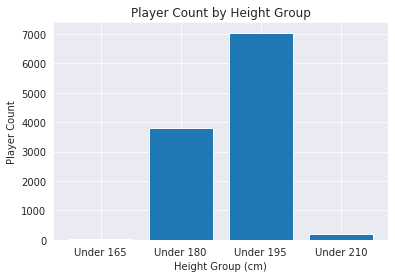

In [38]:
ht = df_player_combined.groupby('height_groups').count()

plt.bar(ht.index, ht.average_rating)
plt.title('Player Count by Height Group')
plt.xlabel('Height Group (cm)')
plt.ylabel('Player Count');

### Observations for Player Height Groups
It is clear that most players are either in the groups of **Under 180** or **Under 195**. Therfore, the insights derived from comparisons of height groups are mostly relevant, i.e. significant, for the aforementioned groups.<br/>
Now, observations will be made on the relationship between overall rating and height group.

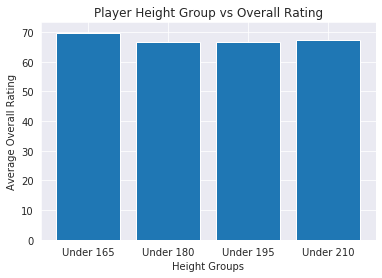

In [39]:
ht = df_player_combined.groupby('height_groups').mean()
 
plt.bar(ht.index, ht.average_rating)
plt.title('Player Height Group vs Overall Rating')
plt.xlabel('Height Groups')
plt.ylabel('Average Overall Rating');

### Observations for Player Height Group vs Overall Rating
It appears as though the average overall rating does not differ much between height groups, with only the **Under 165** category having relatively significant difference.

### Q2: Relationship between Player Age and thier Overall Rating
This question requires the analysis of a dependent variable (overall rating) to an independent variable (player age). To support any observations, the independent variable will first be examined, and then the relationship will be drawn.

Only the `df_player_combined` dataframe will be required for this analysis.

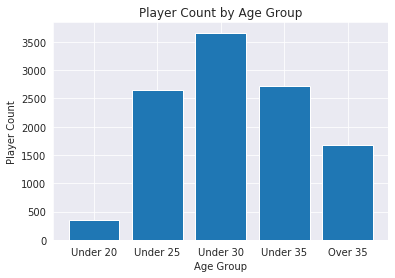

In [40]:
ag = df_player_combined.groupby('age_group').count()

plt.bar(ag.index, ag.average_rating)
plt.title('Player Count by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Player Count');

### Observations for Player Age Groups
There is a good distribution of the number of players based on their age group. Player count increases from the age group of **Under 20** to the age group of **Under 30**, after which it decreases. Therfore, most players appear to be between the ages of 25 to 30.

Now, observations will be made on the relationship between overall rating and age group.

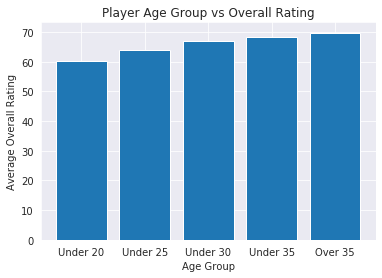

In [41]:
ag = df_player_combined.groupby('age_group').mean()
 
plt.bar(ag.index, ag.average_rating)
plt.title('Player Age Group vs Overall Rating')
plt.xlabel('Age Group')
plt.ylabel('Average Overall Rating');

### Observations for Player Age Group vs Overall Rating
The average overall rating appears to increase, almost linearly, as a player's age increases.<br/>
This is perhaps best visualized with a line plot.

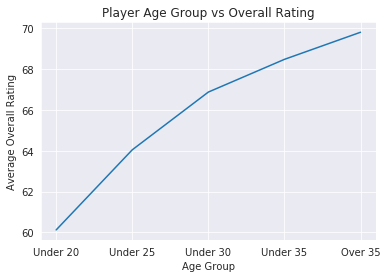

In [42]:
plt.plot(ag.index, ag.average_rating)
plt.title('Player Age Group vs Overall Rating')
plt.xlabel('Age Group')
plt.ylabel('Average Overall Rating');

The line plot now clarifies observations. In fact, it indicates that the overall rating does not vary linearly with the age group, but rather has a declining rate of increase, i.e. it is almost parabolic in nature.

### Q3: Which Team has the Highest, and which has the Lowest Win/Loss Ratio?
This question requires the analysis of independent variables.

Only the `wins` and `losses` dataframes will be required for this analysis.

There are a few ways to interpret this question:  
1. Win/Loss ratio by goal count  
2. Win/Loss ratio by number of games

For this analysis, the win/loss ratio will follow the former, i.e. by goal count.

In [43]:
# Counting all goals for each winning and losing team
total_wins = wins.drop(columns=['match_api_id']+positions).groupby('team_api_id').sum()
total_losses = losses.drop(columns=['match_api_id']+positions).groupby('team_api_id').sum()

In [44]:
total_team_stats = pd.merge(total_wins, total_losses, on="team_api_id", suffixes=('_win', '_loss')).groupby('team_api_id').sum()
total_team_stats['wl_ratio'] = total_team_stats.iloc[:, 0]/total_team_stats.iloc[:, 1]

In [45]:
total_team_stats = pd.merge(df_team_combined.loc[:, ['team_api_id', 'team_short_name']], total_team_stats, on='team_api_id').drop_duplicates()
total_team_stats.sort_values(by=['wl_ratio'], ascending=False)

,team_api_id,team_short_name,goal_win,goal_loss,wl_ratio
347,9773,POR,494,8,61.750000
421,8634,BAR,779,21,37.095238
381,8548,RAN,295,8,36.875000
365,9772,BEN,509,18,28.277778
165,9823,BMU,591,22,26.863636
...,...,...,...,...,...
110,9746,LEH,10,17,0.588235
315,6631,DOR,7,12,0.583333
379,6547,PEN,8,14,0.571429
142,108893,ARL,5,9,0.555556


### Observations for Win/Loss Ratio
`POR` has the highest win/loss ratio, being 61.75.<br/>
`COR` has the lowest win/loss ratio, being 0.40

### Q4: What are the Attributes for the Team which has the Highest Win/Loss Ratio?
This question depends on the results of the previous question. Therefore, the team attributes of the `POR` team will be considered for the team with the highest, and `COR` for the lowest.

The results will be represented in a two separate pie charts, for better comparison, and since the categories are qualitative labels.

In [46]:
hl_ratio = total_team_stats.sort_values(by=['wl_ratio'], ascending=False).head(1).append(total_team_stats.sort_values(by=['wl_ratio'], ascending=False).tail(1))
hl_attrs = pd.merge(df_team_combined, hl_ratio.team_api_id, on='team_api_id')

hl_attrs

,team_api_id,team_short_name,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,9773,POR,2014-09-19,52,50,53,56,66,68,58,60,60
1,9773,POR,2015-09-10,70,50,53,56,66,68,58,60,60
2,7869,COR,2014-09-19,40,53,53,40,66,48,36,41,52
3,7869,COR,2015-09-10,53,40,48,55,59,57,38,39,52


Since the team attributes are unique, at different dates, an average will be taken for comparison.

In [47]:
avg_attrs = hl_attrs.drop(columns='team_api_id').groupby('team_short_name').mean()
avg_attrs

,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
team_short_name,,,,,,,,,
COR,46.5,46.5,50.5,47.5,62.5,52.5,37.0,40.0,52.0
POR,61.0,50.0,53.0,56.0,66.0,68.0,58.0,60.0,60.0


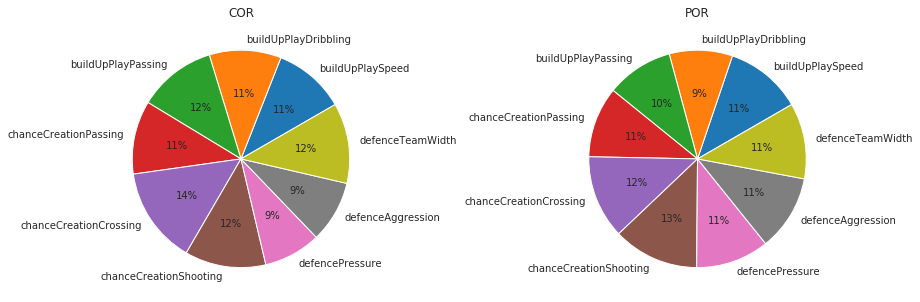

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, (idx, row) in enumerate(avg_attrs.iterrows()):
    ax = axes[i]
    row = row[row.gt(row.sum() * .01)]
    ax.pie(row, labels=row.index, startangle=30, autopct='%1.0f%%')
    ax.set_title(idx)

fig.subplots_adjust(wspace=.2)

### Observations for Team Attribute Breakdown
The composition of team attributes between `COR` (lowest win/loss ratio) and `POR` (highest win/loss ratio) are similar. However, this does not offer insight into the values of each attribute category. Therefore, a bar chart will be plot to gain a better understanding of the team attribute differences.

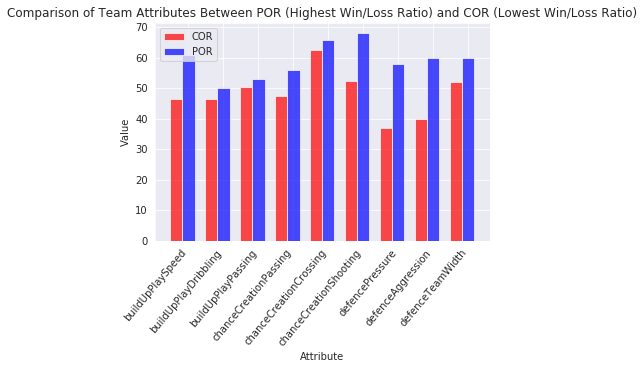

In [49]:
colors = ['r', 'b']
width = 0.35    # the width of the bars
labels = avg_attrs.columns  # xtick labels
ind = np.arange(len(avg_attrs.columns))

# plot bars
for i, (idx, row) in enumerate(avg_attrs.iterrows()):
    row = row[row.gt(row.sum() * .01)]
    plt.bar(np.arange(len(row.index)) + i * width, row.values, width, color=colors[i], alpha=.7, label=idx)

# title and labels
plt.ylabel('Value')
plt.xlabel('Attribute')
plt.title('Comparison of Team Attributes Between POR (Highest Win/Loss Ratio) and COR (Lowest Win/Loss Ratio)')
locations = ind + width  # xtick locations
plt.xticks(locations, labels, rotation=50, ha='right')

# legend
plt.legend();

### Observations for Team Attribute Breakdown on the Bar Chart
The observations on the bar chart indicate that `POR` has higher attribute values for every category compared to `COR`. Most notably, the `defencePressure`, `defenceAggression` and `defenceTeamWidth`, i.e. team defence categories are much higher for `POR` than `COR`. This leads to a more informative insight than what the pie chart has indicated.

<a id='conclusions'></a>
## Conclusions

Based on the given dataset of European Football, relevant questions have been proposed regarding players and teams. Pandas dataframes have been the choice of interacting with the data, whereby data has been imported into dataframes by way of SQL queries. Granted the relevancy of the question categories, the datasets have been cleaned to remove betting data, duplicates, as well as null values, where applicable. It is noted that many of the data cleaning operations could have been performed directly by way of more advanced SQL queries, but to keep the format of this report consistent, dataframes have been selected as the main method of interaction.

**A Note on Results**<br/>
The analysis of each question highlights the dataframe(s) used, and alternatives for interpreting the analysis process for the propsed questions. It is important to note that the results in this analysis are not conclusive, that is, they do not provide statistical backing. Therefore, they should only be considered as groundwork for further investigation.

**Player Attributes**<br/>
Questions propsed regarding player attributes are focused on the relation between a player's overall rating and physical attributes, namely height and age. In this analysis heights and ages have been grouped to improve legibility of plots and improve their interpretation.<br/>
From the plots, it appears as though a player's height does not correlate strongly with their overall rating, however, age appears to exhibit a positive correlation.  Specifically, a line plot of age vs overall rating indicates that the relationship may follow a somewhat parabolic path, i.e. there appears to be a diminishing rate of increase of overall rating with age. Reiterating - these results are inconclusive, rather these are visual observations, a particularly relevant point given the disparity in player height groups, since analysis is not well represented for players in the groups of "Under 165" and "Under 210".

**Team Attributes, Wins and Losses**<br/>
Questions proposed under this category aim to uncover insights on the most, and least victorious teams. As a metric for this comparison, since teams might have played different numbers of matches, the win/loss ratio is focused on. Similarly to the player attributes analysis, these results are inconclusive.<br/>

Wins and losses for each team are read into separate dataframes, from which the win/loss ratios are calculated. Results have indicated that `POR` has the highest win/loss ratio at 61.75, whilst `COR` has the lowest, at 0.40.<br/>
Further analysis has focused on these two teams, to uncover insights regarding the team attributes' influence on performance. It is seen that these two teams have very similar team attribute compositions, i.e. the relative ratios (percentages) of their build-up, chance creation, and defence are similar. The major difference is observed when considering value-level data, whereby the higher-performing team exhibited higher attribute values in every category. Most notably, the defence attribute values are significantly higher for `POR` than `COR`. Note that these results are only specific to these two teams; analysis of every team should be performed before drawing conclusions on the relationship between team attributes and performance.

## Limitations
This analysis does not provide any statistical backing to results, and only makes observations based on visual results from plots. In many cases, comparisons are made on groups of data, or a limited subset of data, and thus, will be insufficient for direct statistical analysis.

## Recommendations
There are many questions which may be focused on given the size of the dataset; understanding this, the dataframes in this report have included metrics such as player positions, should further analysis be required. Below are a list of questions which may be asked to uncover more insights into team performance by country, season, and other team attributes:
- Which team formations are associated with the most goals in a winning game?
- How many home wins are there by match country?
- How many away wins are there by match country?
- How have teams improved the between 2008 and 2016?

Furthermore, given that this report has omitted betting data entirely, it is recommended that this factor be analyzed, for instance to understand which betting organization has the highest accuracy. Such insights will be useful if betting on matches.

Most importantly, for any actionable insights to come of these comparisons, more advanced statistical approaches should be implemented, such as the use of support vector machines, or regression.
